In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics
import scipy.sparse as sp
from tqdm import tqdm 

from torch import nn
import pickle
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.encoder_model import EncoderModel
from celldreamer.models.base.utils import unsqueeze_right

from celldreamer.paths import DATA_DIR

device  = "cuda" if torch.cuda.is_available() else "cpu"

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
def save_pickle(path, obj):
    """
    Save an object to a pickle file.
    
    Args:
        path (str): The file path to save the pickle file.
        obj : The object to be saved.
    """
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

## Step 1: Initialize data

In [3]:
dataset_config = {'dataset_path': DATA_DIR / 'processed_full_genome' / 'hlca_core.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['cell_type'],
                    'conditioning_covariate': 'cell_type',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': True,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': None}

data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                                layer_key=dataset_config["layer_key"],
                                covariate_keys=dataset_config["covariate_keys"],
                                subsample_frac=dataset_config["subsample_frac"], 
                                encoder_type=dataset_config["encoder_type"],
                                target_max=dataset_config["target_max"], 
                                target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}
scaler = dataset.get_scaler()
n_cat = len(dataset.id2cov["cell_type"])

id2cov = dataset.id2cov

del dataset

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Step 2: Initialize encoder

In [4]:
encoder_config = {
    "x0_from_x_kwargs": {
        "dims": [512, 256, 100],
        "batch_norm": True,
        "dropout": False,
        "dropout_p": 0.0
    },
    "learning_rate": 0.001,
    "weight_decay": 0.00001,
    "covariate_specific_theta": False
}

state_dict_path = "/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/train_autoencoder_hlca_core_whole_genome/2b3472e3-d3f6-4f1b-8199-ceac93f9fcc5/checkpoints/last.ckpt"

In [5]:
encoder_model = EncoderModel(in_dim=in_dim,
                              scaler=scaler, 
                              n_cat=n_cat,
                              conditioning_covariate=dataset_config["conditioning_covariate"], 
                              encoder_type=dataset_config["encoder_type"],
                              **encoder_config)
encoder_model.eval()

encoder_model.load_state_dict(torch.load(state_dict_path)["state_dict"])

<All keys matched successfully>

## Step 3: Initialize FM model

In [6]:
generative_model_config = {'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'sigma': 0.5}

In [7]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_resnet_autoencoder_hlca_core_whole_genome/54d1efe9-12d1-4777-9288-cf81a31e7bfa/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]
denoising_model.multimodal = False

In [8]:
ckpt["hyper_parameters"]

{'encoder_model': EncoderModel(
   (x0_from_x): MLP(
     (net): Sequential(
       (0): Sequential(
         (0): Linear(in_features=27997, out_features=512, bias=True)
         (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
       )
       (1): Sequential(
         (0): Linear(in_features=512, out_features=256, bias=True)
         (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
       )
       (2): Linear(in_features=256, out_features=100, bias=True)
     )
   )
   (x_from_x0): MLP(
     (net): Sequential(
       (0): Sequential(
         (0): Linear(in_features=100, out_features=256, bias=True)
         (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
       )
       (1): Sequential(
         (0): Linear(in_features=256, out_features=512, bias=True)
         (1): BatchNorm1d(512, eps=1

In [9]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["cell_type"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[ 1.5741, -0.2471, -1.3416,  ..., -0.4168, -1.3135,  1.1697],
        [ 0.6959,  0.3012,  0.8644,  ..., -0.0301, -0.6848, -0.2299],
        [-0.7654, -0.1246, -3.0543,  ..., -0.9894, -0.0775, -0.3085],
        ...,
        [ 0.5426,  0.4148,  2.1749,  ...,  0.2663,  0.1476, -0.4564],
        [ 0.6478,  0.6404,  1.6064,  ..., -1.5399, -0.4426,  0.0450],
        [ 0.5075, -0.4532, -0.7721,  ...,  0.7354,  0.6425, -0.5204]],
       device='cuda:0', requires_grad=True)


Initializations

In [10]:
generative_model = FM(
            encoder_model=encoder_model,
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=512,
            size_factor_statistics=size_factor_statistics,
            scaler=scaler,
            encoder_type=dataset_config["encoder_type"],
            conditioning_covariate=dataset_config["conditioning_covariate"],
            model_type=denoising_model.model_type, 
            **generative_model_config  # model_kwargs should contain the rest of the arguments
            )
generative_model.denoising_model.embed_size_factor = True
generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'encoder_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder_model'])`.
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (encoder_model): EncoderModel(
    (x0_from_x): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=27997, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (2): Linear(in_features=256, out_features=100, bias=True)
      )
    )
    (x_from_x0): MLP(
      (net): Sequential(
        (0): Sequential(
          (0): Linear(in_features=100, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ELU(alpha=1.0)
        )
        (1): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
       

In [11]:
del ckpt
del encoder_model

## Read original data 

In [12]:
adata_original = sc.read_h5ad(data_path)
sc.pp.subsample(adata_original, fraction=0.2)
adata_original.X = adata_original.layers["X_counts"].copy()
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)

## Generate and save cells

In [13]:
unique_classes = np.unique(adata_original.obs.cell_type, return_counts=True)
unique_classes = dict(zip(unique_classes[0], unique_classes[1]))
unique_classes

{'B cell': 933,
 'CD1c-positive myeloid dendritic cell': 1878,
 'CD4-positive, alpha-beta T cell': 4317,
 'CD8-positive, alpha-beta T cell': 5739,
 'T cell': 95,
 'acinar cell': 252,
 'alveolar macrophage': 15845,
 'alveolar type 1 fibroblast cell': 1044,
 'alveolar type 2 fibroblast cell': 2042,
 'bronchial goblet cell': 328,
 'bronchus fibroblast of lung': 278,
 'brush cell of trachebronchial tree': 32,
 'capillary endothelial cell': 4661,
 'ciliated columnar cell of tracheobronchial tree': 6971,
 'classical monocyte': 3522,
 'club cell': 7175,
 'conventional dendritic cell': 53,
 'dendritic cell': 55,
 'elicited macrophage': 5638,
 'endothelial cell of lymphatic vessel': 966,
 'epithelial cell of alveolus of lung': 300,
 'epithelial cell of lower respiratory tract': 849,
 'fibroblast': 44,
 'hematopoietic stem cell': 14,
 'ionocyte': 115,
 'lung macrophage': 937,
 'lung neuroendocrine cell': 40,
 'lung pericyte': 591,
 'mast cell': 1335,
 'mesothelial cell': 54,
 'mucus secreting ce

In [14]:
del denoising_model

General conditional

In [15]:
# dataset.id2cov

In [16]:
X_generated_list = []
classes_str = []
for _ in tqdm(range(500)):
    num_indices =1000
    index_range = len(adata_original)
    
    # Generate random dummy indices without replacement
    indices = random.sample(range(index_range), num_indices)
    adata_indices = adata_original[indices]
    
    classes =  list(adata_indices.obs.cell_type)
    classes_str += classes
    classes = torch.tensor([id2cov["cell_type"][c] for  c in classes]).cuda()
    log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()
    del adata_indices
    
    X_generated = generative_model.batched_sample(batch_size=100,
                                                repetitions=10,
                                                n_sample_steps=2, 
                                                covariate="cell_type", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)
    
    X_generated_list.append(X_generated)

100%|██████████| 500/500 [13:05<00:00,  1.57s/it]


In [2]:
# # X_generated_list = torch.cat(X_generated_list, dim=0)
# # del X_generated_list
# del adata_original
# del X_generated
# del generative_model

In [19]:
save_pickle("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/hlca_core.pkl", 
            [X_generated_list, classes_str])

In [ ]:
X_generated_list = torch.cat(X_generated_list, dim=0)

In [ ]:
X_generated_list.shape

### Generate single condition

In [3]:
# id2cov["cell_type"]

In [23]:
# # Pick condition 
# condition_name = 'alveolar macrophage'
# condition_val = id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate).long()
# classes_str = [condition_name for _ in range(n_to_generate)]


# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()


# X_generated = generative_model.sample(batch_size=n_to_generate,
#                                         n_sample_steps=100, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

In [24]:
# Oversample
# condition_name = "smooth muscle cell"
# condition_val = id2cov["cell_type"][condition_name]
# adata_cond = adata_original[adata_original.obs.cell_type==condition_name]
# n_to_generate = adata_cond.shape[0]

# classes = condition_val*torch.ones(n_to_generate*10).long()
# classes_str = [condition_name for _ in range(n_to_generate*10)]

# log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda().repeat(10,1)

# X_generated = generative_model.sample(batch_size=n_to_generate*10,
#                                         n_sample_steps=100, 
#                                         covariate="cell_type", 
#                                         covariate_indices=classes, 
#                                         log_size_factor=log_size_factors)

# X_generated_list= X_generated.to("cpu")

## Preprocess and dump generated data

In [27]:
adata_generated = sc.AnnData(X=sp.csr_matrix(deepcopy(X_generated).cpu().numpy()))

adata_generated.obs["size_factor"] = adata_generated.X.sum(1)
adata_generated.obs["cell_type"] = classes_str
adata_generated.obs["cell_type"] = adata_generated.obs["cell_type"].astype("category")
adata_generated.layers["X_counts"] = adata_generated.X.copy()

In [28]:
sc.pp.normalize_total(adata_generated, target_sum=10000)
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:346: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style' in a future release. See details at https://numba.readthedocs.io/en/latest/reference/deprecation.html#deprecation-of-old-style-numba-captured-errors
Exception origin:
  File "/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/numba/core/types/functions.py", line 486, in __getnewargs__
    raise ReferenceError("underlying object has vanished")

  init_rp_tree(data, dist, current_graph, leaf_array)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pynndescent/pynndescent_.py:348: NumbaPendingDeprecationWarning: Code using Numba extension API maybe depending on 'old_style' error-capturing, which is deprecated and will be replaced by 'new_style'

In [29]:
sc.pl.pca(adata_generated, color=["size_factor", "cell_type"], annotate_var_explained=True)
sc.pl.umap(adata_generated, color=["size_factor", "cell_type"])

## Preprocess real data object

In [ ]:
sc.pp.normalize_total(adata_original, target_sum=10000)
sc.pp.log1p(adata_original)
sc.tl.pca(adata_original)
sc.pp.neighbors(adata_original)
sc.tl.umap(adata_original)

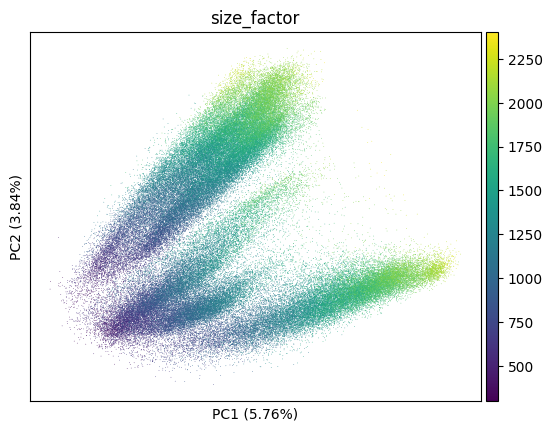

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


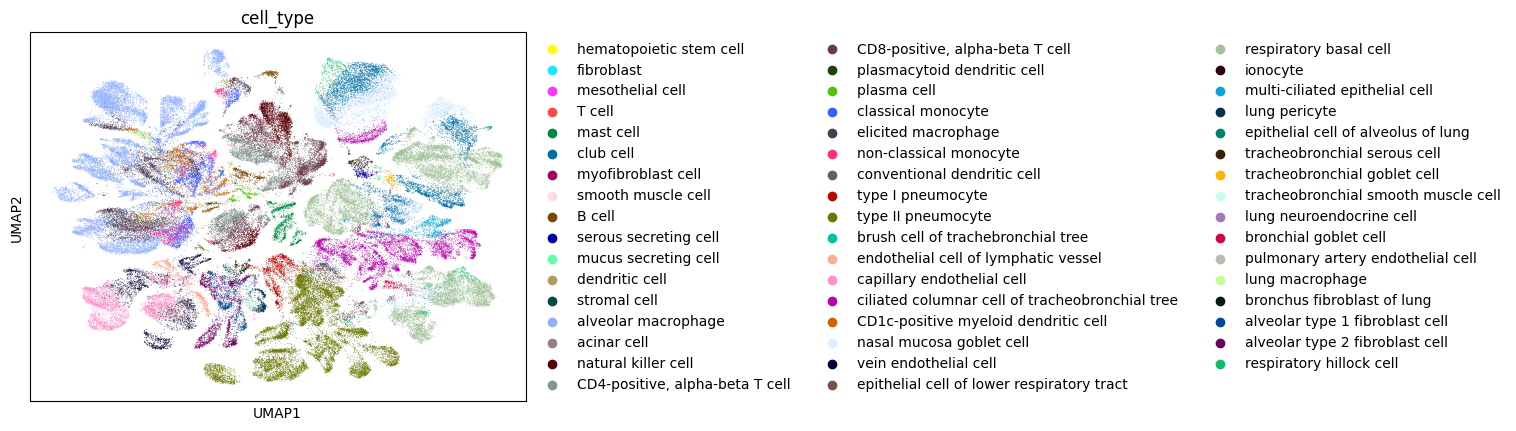

In [31]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="cell_type")

In [ ]:
# adata_generated.write_h5ad("/home/icb/alessandro.palma/environment/celldreamer/project_folder/datasets/generated/hlca_core.h5ad")

## Merge and plot the generated and real data

In [33]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated_list.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]
dataset_type["cell_type"] = list(adata_original.obs.cell_type)+list(classes_str)

In [34]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated_list], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [35]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


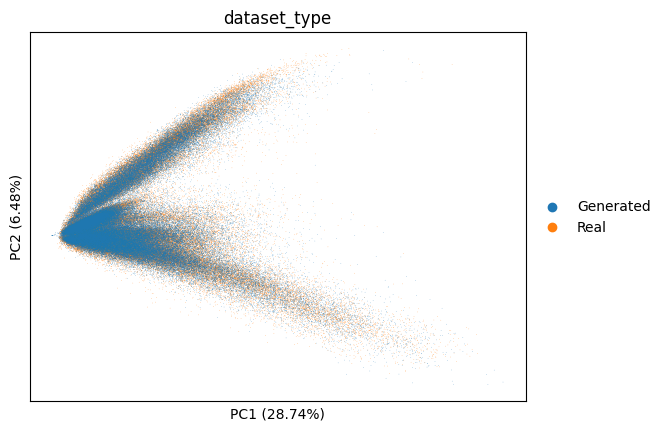

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

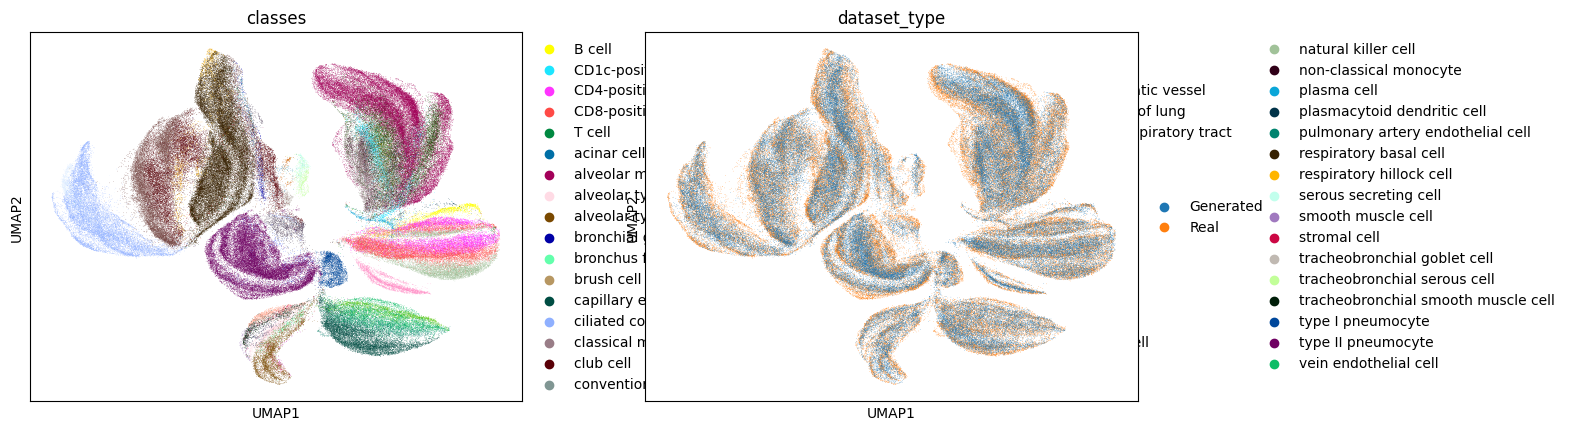

In [36]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color="dataset_type")
sc.pl.umap(adata_merged, color="cell_type")

## Only for single-class generation

In [4]:
# sc.pl.umap(adata_merged, color=["classes"], s=10, groups="smooth muscle cell")

In [5]:
# sc.pl.umap(adata_merged[adata_merged.obs.dataset_type=="Real"], color=["classes"], s=10, groups="smooth muscle cell")